In [1]:
# The script to analyse local structure 
# ASE python follwoing packages 
# 1. Neightbourlist 
# 2. Connectivity matrix  
# 3. Bond analysis 
from ase import neighborlist
from ase.data import covalent_radii 
from ase.calculators.neighborlist import NeighborList
from ase.neighborlist import neighbor_list
from ase.io import read, write 
from ase import Atoms 
from scipy import sparse
import numpy as np 
from ase.io.pov import get_bondpairs 

# Import the structure for analysis 
strcut = read("300k_amorphous_ordered.cif", format="cif")       

/nfshome/deshmukh/.local/lib/python3.9/site-packages/ase/calculators/neighborlist.py:5: UserWarning: Moved to ase.neighborlist
  warnings.warn('Moved to ase.neighborlist')


In [2]:
# Get the symbols
symbols = [] 
for i in range(len(strcut)):
    symbols.append(strcut.symbols[i])

# Get neighbour list 
def nn(structure, cut):
    cutOff  = cut * covalent_radii[structure.numbers]    # 1.6 initial
    neighborList = neighborlist.NeighborList(cutoffs=cutOff, self_interaction=False, bothways=True)
    neighborList.update(structure)
    return neighborList

In [3]:
nl = nn(structure=strcut, cut=1.6)
matrix = nl.get_connectivity_matrix()   # No use in my case 

In [4]:
# Get index for each elements 
Zr_index = [strcu.index for strcu in strcut if strcu.symbol == "Zr"]
O_index = [strcu.index for strcu in strcut if strcu.symbol == "O"]
Si_index = [strcu.index for strcu in strcut if strcu.symbol == "Si"]
#del strcut[[Si_index]]
P_index = [strcu.index for strcu in strcut if strcu.symbol == "P"]
#del strcut[[P_index]]
Na_index = [strcu.index for strcu in strcut if strcu.symbol == "Na"]

In [5]:
# Sort 'Na' which are not in the vicinity of the O, and Na
indi = []
for i in Na_index:
    indices, offsets = nl.get_neighbors(i)
    indi.append(indices)

Na_index_k = []     # Interacting (Low diffusion)
O_index_k = []      # Interacting 
for i, k in zip(Na_index, indi):
    for j in k: 
        if strcut.symbols[j]=='Na' or strcut.symbols[j]=='O':
            dist = strcut.get_distance(i,j) 
            if dist<2.5:
                if strcut.symbols[j]=='Na':
                    Na_index_k.append(j)
                    Na_index_k.append(i)
                elif strcut.symbols[j]=='O':
                    O_index_k.append(j)
non_na = list(set(Na_index_k).symmetric_difference(set(Na_index))) # Non interacting sodium (Low diff.)
int_na = set(Na_index_k) 

In [6]:
from ase.io.pov import get_bondpairs
from collections import defaultdict

common_neighbors = defaultdict(list)
neig_o = []   # oxygen 
neig_zr =[]   # Zrconium
bondpairs_z_o = []
bondpairs_o_z = []

for i in Zr_index:
    indices, offsets = nl.get_neighbors(i)
    for j, offset in zip(indices, offsets):
        if strcut.symbols[j]=='O' or strcut.symbols[j]=='Zr':
            dist = strcut.get_distance(i,j)
            if dist<=2.5:
                if i != j:
                    bondpairs_z_o.extend([(i,j)])
                    neig_o.extend([(j)])
                    common_neighbors[(i, j)].append(j)

for i in neig_o:
    indices, offsets = nl.get_neighbors(i)
    for j, offset in zip(indices, offsets):
        if strcut.symbols[j]=='Zr':
            dist = strcut.get_distance(i,j)
            if dist<=2.5:
                if i != j:
                    bondpairs_o_z.extend([(i,j)])
                    neig_zr.extend([(j)])
                    #common_neighbors[(i, j)].append(j)


In [7]:
# Get zirconium in from the bond 
Zr_list_O = []
Zr_list_Zr = []
for i, j in bondpairs_o_z:
    Zr_list_O.append(i)
    Zr_list_Zr.append(j)

# In cluster which has Zr and O 
# There is common Zr and O, either Zr is common then O is uncommon and vice versa 
# Here, Zr share Zr using common O, O are shared via common Zr 
# For Zr, we are focusing on common Zr, which means it is repetatively involved in diff. Zr-O bond 
# In that, if repetation is more than 6 then those Zr is involved in cluster
# In normal Zr, Zr attachechd to 6 Oxygen atoms
# Therfore, I am making a list of most common Zr and O    

Zr_comm = []
O_comm = []

from collections import Counter
c = Counter(Zr_list_O)
d = Counter(Zr_list_Zr)
for i, j in c.items():
    #if j >= 3:
    O_comm.append(i)
for i, j in d.items():
    #if j > 4:
    Zr_comm.append(i)

print(f'The given system has most common Zr = {len(Zr_comm)} and O = {len(O_comm)}.'.format(len(Zr_comm),len(O_comm))) 

The given system has most common Zr = 108 and O = 432.


In [8]:
Zr_O_new = []
Zr_new = []

for i in Zr_comm:
    Zr_new.append(i)
    new = [j for j in O_comm if (strcut.get_distance(i,j)<=2.5)]
    Zr_O_new.append(new)

import pandas as pd 

df = pd.DataFrame(Zr_new,columns = ["Common_Zr"])
df["O_1"] = Zr_O_new
df

,Common_Zr,O_1
0,0,"[860, 561, 764, 365, 772, 720]"
1,11,"[860, 561, 553, 321, 560, 296]"
2,58,"[561, 772, 767, 685, 822, 502]"
3,55,"[764, 365, 374, 915, 457, 544]"
4,45,"[365, 531, 490, 579, 549, 527]"
...,...,...
103,78,"[498, 667, 827]"
104,95,"[775, 375, 897, 839]"
105,96,"[712, 878, 446, 276, 382]"
106,98,[385]


In [9]:
s=df.explode('O_1')
s=s.merge(s,on='O_1').query('Common_Zr_x ! = Common_Zr_y').groupby(['Common_Zr_x','Common_Zr_y']).O_1.apply(list)
l={x: y.reset_index(level=0,drop=True).to_dict()for x , y in s.groupby(level=0)}
df['Common']=pd.Series(l).reindex(df.Common_Zr).values
df

,Common_Zr,O_1,Common
0,0,"[860, 561, 764, 365, 772, 720]","{11: [860, 561], 45: [365], 55: [764, 365], 58..."
1,11,"[860, 561, 553, 321, 560, 296]","{0: [860, 561], 58: [561], 69: [553], 83: [321..."
2,58,"[561, 772, 767, 685, 822, 502]","{0: [561, 772], 11: [561], 21: [767], 83: [822..."
3,55,"[764, 365, 374, 915, 457, 544]","{0: [764, 365], 10: [374], 45: [365], 97: [457]}"
4,45,"[365, 531, 490, 579, 549, 527]","{0: [365], 55: [365]}"
...,...,...,...
103,78,"[498, 667, 827]",{106: [498]}
104,95,"[775, 375, 897, 839]",NaN
105,96,"[712, 878, 446, 276, 382]",NaN
106,98,[385],NaN


In [10]:
zr_list = []   # Connected Zr
o_list = []    # Connected O
zr_id = []     # ID 
for i, j in zip(l.keys(), l.values()):
    o  = [k for k in j.values()]
    zr = [k for k in j.keys()]
    zr_list.append(zr)
    o_list.append(o)
    zr_id.append(i)

In [11]:
fout = "cluster_zr_1.txt"
fo = open(fout, "w")
for k, v in l.items():
    fo.write(str(k) + ' '+ str(v) + '\n')
fo.close()

In [12]:
with open('cluster_zr_1.txt', 'r') as my_file:
    text = my_file.read()
    text = text.replace(" {", ", ")
    text = text.replace("}", "")
    text = text.replace(":", ",")
    text = text.replace("[", "")
    text = text.replace("]", "")

# If you wish to save the updates back into a cleaned up file
with open('cluster_zr_2.txt', 'w') as my_file:
    my_file.write(text)

In [13]:
with open("cluster_zr_2.txt") as f:
    content = f.readlines()
content = [l.strip() for l in content if l.strip()]

In [14]:
data = [string.split() for string in content]

In [16]:
import networkx as nx 
G=nx.Graph()
for l in data:
    nx.add_path(G, l)
new_data = list(nx.connected_components(G))
pos = nx.spring_layout(G, scale=20, k=2/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightgreen', node_size=1000, with_labels=True)

TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>

In [17]:
with open('cluster_zr_2.txt', 'w') as my_file:
    for i in new_data:
        my_file.write(str(i) + '\n')

In [18]:
with open('cluster_zr_2.txt', 'r') as my_file:
    text = my_file.read()
    text = text.replace("{", "")
    text = text.replace("}", "")
    text = text.replace("'", "")
    text = text.replace(",'", " ")
    #text = text.replace("", ",")

# If you wish to save the updates back into a cleaned up file
with open('cluster_zr_3.txt', 'w') as my_file:
    my_file.write(text)

In [19]:
with open('cluster_zr_3.txt', 'r') as my_file:
    text = my_file.read()
    text = text.replace(",,", ",")
with open('cluster_zr_4.txt', 'w') as my_file:
    my_file.write(text)

with open('cluster_zr_4.txt', 'r') as my_file:
    text = my_file.read()
    text = text.replace(", ,", " ,")
    text = text.replace(",]", "]")
with open('cluster_zr_4.txt', 'w') as my_file:
    my_file.write(text)

In [20]:
with open("cluster_zr_4.txt") as f:
    content_1 = f.readlines()
content_1 = [l.strip() for l in content_1 if l.strip()]
data_1 = [l.strip() for l in content_1 if l.strip()]

In [21]:
import re
df_1 = pd.DataFrame(data_1,columns = ["List"])  
l = df_1['List'].apply(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+", x)).tolist()

In [22]:
zr_pos = []
sym = []
for i in l:
    for k in i:
        zr_pos.append(strcut.positions[int(k)])
        sym.append(strcut.symbols[int(k)])

for i in int_na:
    zr_pos.append(strcut.positions[int(i)])
    sym.append(strcut.symbols[int(i)])

In [23]:
# Build Atoms object excluding atoms in boundaries
finalsupercell = Atoms(
        positions=zr_pos,
        cell=strcut.cell,
        symbols=sym,
        pbc=strcut.pbc)

# Write to file
write("finalsupercell.xyz", finalsupercell)

In [24]:
coun = [] 
for i in new_data:
    coun.append(len(i))

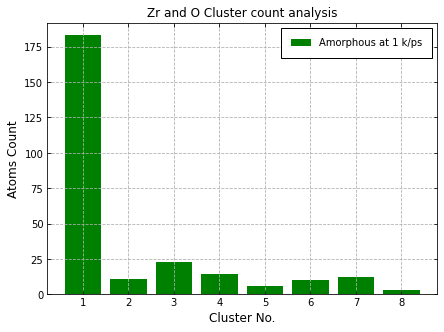

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,5)
#plt.xlim([0, 14])
#plt.ylim([0, 100])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
#plt.plot(range(99), cluster)
plt.bar(range(1,9,1), coun,label='Amorphous at 1 k/ps', color = 'green')
#plt.axhline(y = sum(coun)/len(coun), color = 'black', linestyle = '--', label='Average size = {} +/- {}'.format(round(sum(coun)/len(coun)),round(np.std(coun))))
plt.grid(which='both')
plt.grid(True, linestyle='--')
plt.title("Zr and O Cluster count analysis")
plt.xlabel("Cluster No.", fontsize=12)
plt.ylabel("Atoms Count", fontsize=12)
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black")
plt.savefig("zr_o_cluster_amo_10.png", bbox_inches='tight', dpi=600, transparent=False)

In [26]:
# Cordination number analysis for Zr and O atoms 
# Here I am using Pyscal to perform CN analysis 
import pyscal.core as pc
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read

st = read("300k_amorphous_ordered.cif", format="cif")

sys = pc.System()
sys.read_inputfile(st, format="ase")
sys.find_neighbors(method='cutoff', cutoff=4.0)
atoms = sys.atoms

Text(0.5, 1.0, 'Cutoff method')

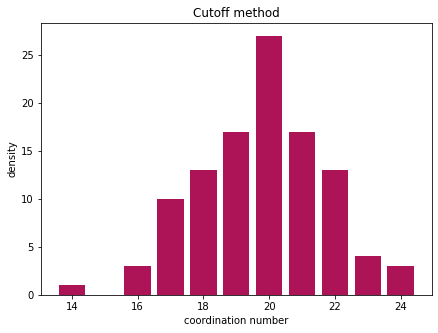

In [27]:
#for i in Zr_index:
coord = [atom.coordination for atom in atoms if atom.type == 5]
nos, counts = np.unique(coord, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff method")

In [28]:
import sys

from datetime import datetime
import numpy as np
from ase.data import covalent_radii as CR

def get_coordination_numbers(atoms, covalent_percent=1.15):
    """Returns an array of coordination numbers and an array of existing bonds determined by
    distance and covalent radii.  By default a bond is defined as 120% of the combined radii
    or less. This can be changed by setting 'covalent_percent' to a float representing a 
    factor to multiple by (default = 1.2).
    If 'exclude' is set to an array,  these atomic numbers with be unable to form bonds.
    This only excludes them from being counted from other atoms,  the coordination
    numbers for these atoms will still be calculated,  but will be unable to form
    bonds to other excluded atomic numbers.
    """

    # Get all the distances
    distances = np.divide(atoms.get_all_distances(mic=True), covalent_percent)

    #distances = atoms.get_all_distances()

    # Atomic Numbers
    numbers = atoms.numbers
    # Coordination Numbers for each atom
    cn = []
    cr = np.take(CR, numbers)
    # Array of indices of bonded atoms.  len(bonded[x]) == cn[x]
    bonded = []
    loc_struct = []
    indices = list(range(len(atoms)))
    for i in indices:
        bondedi = []
        for ii in indices:
            # Skip if measuring the same atom
            if i == ii:
                continue
            if (cr[i] + cr[ii]) >= distances[i,ii]:
                bondedi.append(ii)
        # Add this atoms bonds to the bonded list
        bonded.append(bondedi)
    for i in bonded:
        cn.append(len(i))
    for i in bonded:
        loc_struct.append(atoms.symbols[i])
    
    return cn, bonded, loc_struct

In [29]:
cn, bonds, loc = get_coordination_numbers(atoms=strcut, covalent_percent=1.2)

In [30]:
print(len(cn),len(bonds),len(loc))

1080 1080 1080


In [31]:
for i, j, k in zip(cn,bonds, loc):
    print(i,j, k)

17 [11, 45, 55, 58, 100, 128, 261, 365, 561, 720, 764, 772, 860, 986, 1022, 1025, 1054] Zr5SiPO6Na4
12 [158, 311, 436, 559, 563, 785, 885, 923, 925, 977, 1044, 1049] SiO6Na5
14 [71, 81, 84, 129, 503, 672, 698, 750, 800, 817, 943, 974, 980, 982] Zr3SiO6Na4
13 [13, 15, 75, 100, 128, 329, 368, 599, 781, 794, 836, 961, 993] Zr4SiO6Na2
12 [38, 40, 53, 255, 314, 418, 450, 601, 611, 790, 990, 1050] Zr3PO6Na2
12 [98, 99, 171, 281, 302, 433, 542, 782, 849, 920, 948, 1069] Zr2SiO6Na3
14 [28, 42, 81, 232, 316, 340, 452, 491, 576, 843, 996, 999, 1001, 1042] Zr3PO6Na4
14 [8, 29, 70, 72, 162, 357, 360, 499, 543, 585, 600, 768, 1044, 1049] Zr4SiO7Na2
16 [7, 29, 33, 139, 168, 357, 493, 499, 551, 696, 874, 928, 975, 1014, 1029, 1041] Zr3Si2O6Na5
13 [15, 75, 577, 638, 694, 704, 879, 912, 955, 966, 993, 997, 1055] Zr2O6Na5
11 [28, 55, 74, 374, 648, 718, 842, 888, 898, 934, 1022] Zr3O6Na2
14 [0, 58, 69, 83, 87, 100, 141, 296, 321, 553, 560, 561, 860, 986] Zr6SiO6Na
12 [37, 203, 231, 596, 598, 689, 819, 88

In [85]:
# In the follwoing I am introducing new criterian for bond creation
# 1. If the distance between two atoms is = 60/100 * sum of their van der waals radii


def get_coordination_numbers(atoms, covalent_percent=1.2):
    """Returns an array of coordination numbers and an array of existing bonds determined by
    distance and covalent radii.  By default a bond is defined as 120% of the combined radii
    or less. This can be changed by setting 'covalent_percent' to a float representing a 
    factor to multiple by (default = 1.2).
    If 'exclude' is set to an array,  these atomic numbers with be unable to form bonds.
    This only excludes them from being counted from other atoms,  the coordination
    numbers for these atoms will still be calculated,  but will be unable to form
    bonds to other excluded atomic numbers.
    """

    # Get all the distances
    distances = np.divide(atoms.get_all_distances(mic=True), covalent_percent)

    #distances = atoms.get_all_distances()

    # Atomic Numbers
    numbers = atoms.numbers
    # Coordination Numbers for each atom
    cn = []
    cr = np.take(CR, numbers)
    # Array of indices of bonded atoms.  len(bonded[x]) == cn[x]
    bonded = []
    loc_struct = []
    indices = list(range(len(atoms)))
    for i in indices:
        bondedi = []
        for ii in indices:
            # Skip if measuring the same atom
            if i == ii:
                continue
            if (cr[i] + cr[ii]) >= distances[i,ii]:
                bondedi.append(ii)
        # Add this atoms bonds to the bonded list
        bonded.append(bondedi)
    for i in bonded:
        cn.append(len(i))
    for i in bonded:
        loc_struct.append(atoms.symbols[i])
    
    return cn, bonded, loc_struct

In [89]:
def get_coordination_numbers(atoms, covalent_percent=1.5):
    """Returns an array of coordination numbers and an array of existing bonds determined by
    distance and covalent radii.  By default a bond is defined as 120% of the combined radii
    or less. This can be changed by setting 'covalent_percent' to a float representing a 
    factor to multiply by (default = 1.2).
    If 'exclude' is set to an array,  these atomic numbers with be unable to form bonds.
    This only excludes them from being counted from other atoms,  the coordination
    numbers for these atoms will still be calculated,  but will be unable to form
    bonds to other excluded atomic numbers.
    """

    # Get all the distances
    distances = atoms.get_all_distances(mic=True)

    # Atomic Numbers
    numbers = atoms.numbers
    # Coordination Numbers for each atom
    cn = []
    cr = np.take(CR, numbers) * covalent_percent  # Corrected here.
    # Array of indices of bonded atoms.  len(bonded[x]) == cn[x]
    bonded = []
    loc_struct = []
    indices = list(range(len(atoms)))
    for i in indices:
        bondedi = []
        for ii in indices:
            # Skip if measuring the same atom
            if i == ii:
                continue
            if (cr[i] + cr[ii]) >= distances[i,ii]:
                bondedi.append(ii)
        # Add this atoms bonds to the bonded list
        bonded.append(bondedi)
    for i in bonded:
        cn.append(len(i))
    for i in bonded:
        loc_struct.append(atoms.symbols[i])
    
    return cn, bonded, loc_struct

In [90]:
cn, bonds, loc = get_coordination_numbers(atoms=strcut)

In [91]:
for i, j, k in zip(cn,bonds, loc):
    print(i,j, k)

24 [11, 21, 45, 55, 58, 87, 100, 128, 241, 261, 296, 365, 394, 561, 720, 739, 764, 772, 860, 986, 992, 1022, 1025, 1054] Zr7SiP2O9Na5
19 [54, 111, 117, 158, 231, 253, 265, 311, 436, 559, 563, 785, 885, 923, 925, 977, 1044, 1049, 1064] ZrSi3P3O6Na6
19 [71, 81, 84, 129, 137, 153, 238, 503, 672, 698, 750, 800, 817, 848, 943, 974, 980, 982, 1042] Zr3Si3PO7Na5
18 [13, 15, 74, 75, 100, 128, 219, 235, 329, 368, 538, 599, 781, 794, 836, 921, 961, 993] Zr5SiP2O7Na3
20 [20, 38, 40, 53, 56, 147, 152, 221, 255, 314, 418, 450, 487, 601, 611, 726, 790, 973, 990, 1050] Zr5Si2P2O8Na3
22 [98, 99, 134, 140, 171, 178, 244, 281, 298, 302, 385, 433, 542, 782, 849, 920, 937, 948, 949, 985, 1020, 1069] Zr2Si4PO8Na7
22 [28, 42, 81, 114, 164, 193, 232, 238, 316, 340, 452, 491, 562, 576, 639, 843, 974, 996, 999, 1001, 1030, 1042] Zr3Si3P2O8Na6
22 [8, 16, 29, 70, 72, 107, 111, 139, 162, 357, 360, 499, 543, 585, 600, 768, 923, 928, 960, 975, 1044, 1049] Zr6Si3O7Na6
21 [7, 29, 33, 107, 139, 168, 190, 357, 493, 499

In [92]:
loc

[Symbols('Zr7SiP2O9Na5'),
 Symbols('ZrSi3P3O6Na6'),
 Symbols('Zr3Si3PO7Na5'),
 Symbols('Zr5SiP2O7Na3'),
 Symbols('Zr5Si2P2O8Na3'),
 Symbols('Zr2Si4PO8Na7'),
 Symbols('Zr3Si3P2O8Na6'),
 Symbols('Zr6Si3O7Na6'),
 Symbols('Zr4Si3O7Na7'),
 Symbols('Zr2Si3PO6Na5'),
 Symbols('Zr5Si3O6Na6'),
 Symbols('Zr7Si3O9Na5'),
 Symbols('Zr2Si4P2O8Na8'),
 Symbols('Zr4SiP2O8Na6'),
 Symbols('Zr5Si3PO6Na7'),
 Symbols('Zr3Si4PO6Na4'),
 Symbols('ZrSi4P2O8Na10'),
 Symbols('Zr7Si2PO7Na3'),
 Symbols('Zr2Si3P2O6Na5'),
 Symbols('Zr5Si4O8Na5'),
 Symbols('Zr7PO7Na4'),
 Symbols('Zr6SiP2O7Na5'),
 Symbols('ZrSi3P2O6Na9'),
 Symbols('ZrSi5PO8Na6'),
 Symbols('Zr4Si2PO7Na5'),
 Symbols('Zr8Si2O8Na3'),
 Symbols('Zr5SiP2O7Na3'),
 Symbols('Zr4Si3O7Na7'),
 Symbols('Zr6Si2O8Na5'),
 Symbols('Zr4Si4PO8Na4'),
 Symbols('Zr3Si2PO7Na7'),
 Symbols('Zr4Si2P2O6Na4'),
 Symbols('Zr4Si6O7Na2'),
 Symbols('Zr4Si2PO7Na6'),
 Symbols('Zr3Si2PO6Na6'),
 Symbols('Zr7Si2O8Na7'),
 Symbols('Zr4Si3P2O7Na5'),
 Symbols('Zr5Si3PO9Na4'),
 Symbols('Zr2Si2P3O